# Step 1: Business Understanding
- Tiki là một hệ sinh thái thương mại “all in one”, trong đó có tiki.vn, là một website thương mại điện tử đứng top 2 của Việt Nam, top 6 khu vực Đông Nam Á.
- Trên trang này đã triển khai nhiều tiện ích hỗ trợ nâng cao trải nghiệm người dùng và họ muốn xây dựng nhiều tiện ích hơn nữa.

Yêu cầu:
- Xây dựng Recommendation System cho một hoặc một số nhóm hàng hoá trên titki.vn giúp đề xuất và gợi ý cho người dùng/ khách hàng => Xây dựng mô hình đề xuất:
- Content-based filtering: ProductRaw.csv
- Collaborative filtering: ReviewRaw.csv

## Import packages

In [ ]:
import pandas as pd
import numpy as np
import pandas_profiling as pp
import matplotlib.pyplot as plt
import seaborn as sns
import import_ipynb
import Lib

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

pd.options.display.float_format = '{:,.4f}'.format

importing Jupyter notebook from Lib.ipynb


In [ ]:
import re
from underthesea import word_tokenize
from gensim import corpora, models, similarities
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Step 2: Data Understanding

## 2.1 Data cleaning

'ProductRaw.csv'

In [ ]:
# Load data 'ProductRaw.csv'
product = pd.read_csv('data/ProductRaw.csv')

In [ ]:
product.shape

(4404, 10)

In [ ]:
product.head(3)

,item_id,name,description,rating,price,list_price,brand,group,url,image
0,48102821,Tai nghe Bluetooth Inpods 12 - Cảm biến vân ta...,THÔNG TIN CHI TIẾT\nDung lượng pin 300\nThời g...,4.0000,77000,300000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-inpods-12-cam-bien-...,https://salt.tikicdn.com/cache/280x280/ts/prod...
1,52333193,Tai nghe bluetooth không dây F9 True wireless ...,THÔNG TIN CHI TIẾT\nDung lượng pin 2000mah\nTh...,4.5000,132000,750000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-khong-day-f9-true-w...,https://salt.tikicdn.com/cache/280x280/ts/prod...
2,299461,Chuột Không Dây Logitech M331 Silent - Hàng Ch...,THÔNG TIN CHI TIẾT\nThương hiệu Logitech\nĐộ p...,4.8000,299000,399000,Logitech,Thiết Bị Số - Phụ Kiện Số/Phụ kiện máy tính và...,https://chuot-khong-day-logitech-m331-silent-p...,https://salt.tikicdn.com/cache/280x280/media/c...


In [ ]:
product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4404 entries, 0 to 4403
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   item_id      4404 non-null   int64  
 1   name         4404 non-null   object 
 2   description  4401 non-null   object 
 3   rating       4404 non-null   float64
 4   price        4404 non-null   int64  
 5   list_price   4404 non-null   int64  
 6   brand        4404 non-null   object 
 7   group        4404 non-null   object 
 8   url          4404 non-null   object 
 9   image        4404 non-null   object 
dtypes: float64(1), int64(3), object(6)
memory usage: 344.2+ KB


In [ ]:
product.describe()

,item_id,rating,price,list_price
count,"4,404.0000","4,404.0000","4,404.0000","4,404.0000"
mean,"34,859,938.0311",3.6782,"2,747,125.0995","3,870,596.1785"
std,"25,681,520.9383",1.7923,"5,528,233.1149","7,877,977.2250"
min,"54,665.0000",0.0000,"7,000.0000","12,000.0000"
25%,"10,768,594.0000",3.8000,"150,000.0000","277,250.0000"
50%,"32,439,644.5000",4.5000,"482,444.0000","790,000.0000"
75%,"56,306,800.5000",4.8000,"2,649,000.0000","3,507,500.0000"
max,"85,042,408.0000",5.0000,"62,690,000.0000","82,990,000.0000"


In [ ]:
# Drop rows where description == null
product = product[product['description'].notnull()]
product.shape

(4401, 10)

In [ ]:
# Check if there is any null value
product.isnull().any()

item_id        False
name           False
description    False
rating         False
price          False
list_price     False
brand          False
group          False
url            False
image          False
dtype: bool

In [ ]:
# Check & drop duplicated rows
print('Number of duplicated rows:',product.duplicated().sum())
product = product.drop_duplicates().reset_index(drop=True)
product.shape

Number of duplicated rows: 31


(4370, 10)

In [ ]:
# Reset index
# product = product.reset_index(drop=True)

'ReviewRaw.csv'

In [ ]:
# Load data 'ReviewRaw.csv'
review = pd.read_csv('data/ReviewRaw.csv')
review.shape

(364099, 8)

In [ ]:
review.head()

,customer_id,product_id,name,full_name,created_time,rating,title,content
0,709310,10001012,Lân Nguyễn Hoàng,Lân Nguyễn Hoàng,NaN,3,Ko dùng đc thẻ nhớ,Lúcđầu quên thông tin nên dùng 512gb thì ko đc...
1,10701688,10001012,Nguyễn Khánh Hòa,Nguyễn Khánh Hòa,NaN,5,Cực kì hài lòng,"Tiki giao hàng nhanh. Sản phẩm đúng như mô tả,..."
2,11763074,10001012,Toàn Phạm Khánh,Toàn Phạm Khánh,2019-04-17 15:42:45,5,Cực kì hài lòng,"chất lượng camera rõ nét, chống mưa nắng tuyệt..."
3,9909549,10001012,Nguyen Quang Minh,NaN,NaN,5,Rất hài lòng,"Hàng được đóng gói cẩn thận, giao hàng nhanh ,..."
4,1827148,10001012,Phạm Bá Đức,Phạm Bá Đức,NaN,5,Cực kì hài lòng,"dễ cài đặt, chất lượng tốt, chế độ xem hồng ng..."


In [ ]:
review = review[['customer_id', 'product_id', 'rating']]
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364099 entries, 0 to 364098
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   customer_id  364099 non-null  int64
 1   product_id   364099 non-null  int64
 2   rating       364099 non-null  int64
dtypes: int64(3)
memory usage: 8.3 MB


In [ ]:
print('Number of duplicated rows:', review.duplicated().sum())
review = review.drop_duplicates().reset_index(drop=True)
review.shape

Number of duplicated rows: 3888


(360211, 3)

In [ ]:
print('Number of unique product in dataframe product:',product.item_id.nunique())
print('Number of unique product in dataframe review:',review.product_id.nunique())

Number of unique product in dataframe product: 4370
Number of unique product in dataframe review: 4218


Nhận xét: 
- Số lượng unique product của 2 dataframe không giống nhau => Có thể có những sản phẩm chỉ thuộc 1 dataframe mà không thuộc dataframe còn lại => Tiến hành kiểm tra

In [ ]:
notin_product = review[~review['product_id'].isin(product['item_id'].unique())]
print('Số lượng sản phẩm có trong "review" mà không có trong "product":', notin_product.shape[0])
notin_review = product[~product['item_id'].isin(review['product_id'].unique())]
print('Số lượng sản phẩm có trong "product" mà không có trong "review":', notin_review.shape[0])

Số lượng sản phẩm có trong "review" mà không có trong "product": 671
Số lượng sản phẩm có trong "product" mà không có trong "review": 159


In [ ]:
# Loại bỏ những sản phẩm không tương đồng 
product = product[product['item_id'].isin(review['product_id'].unique())].reset_index(drop=True)
review = review[review['product_id'].isin(product['item_id'].unique())].reset_index(drop=True)

# Kiểm tra xem review.product_id và product.item_id đã bao gồm những sản phẩm giống nhau hay chưa
sorted(review['product_id'].unique()) == sorted(product['item_id'].unique()) 

True

In [ ]:
# # Save 2 file đã làm sạch
# product.to_csv('data/ProductClean.csv')
# review.to_csv('data/ReviewClean.csv')

## 2.2 EDA

### PRODUCT
### -- Numeric variables

In [ ]:
# Xem thống kê cơ bản của các biến 'rating', 'price', 'list_price'
Lib.univariate_cont_analysis(['rating', 'price', 'list_price'], product)

,mean,median,mode,max_val,min_val,range_val,variance,skewness,kurtosis
var_name,,,,,,,,,
rating,3.8121,4.5000,0 0.0000 dtype: float64,5.0000,0.0000,5.0000,2.8178,-1.6677,1.1034
price,"2,612,385.9691","459,000.0000",0 99000 dtype: int64,"51,990,000.0000","7,000.0000","51,983,000.0000","27,514,779,749,756.5391",3.5320,15.5388
list_price,"3,720,382.5148","750,000.0000",0 150000 dtype: int64,"82,990,000.0000","12,000.0000","82,978,000.0000","58,335,354,437,055.7891",4.1195,23.0395


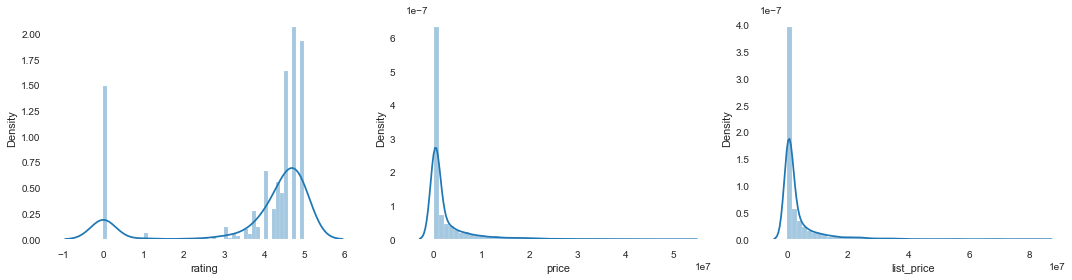

In [ ]:
# Vẽ biểu đồ distplot để xem phân phối của các biến
Lib.visualization_distplot(['rating', 'price', 'list_price'], product)

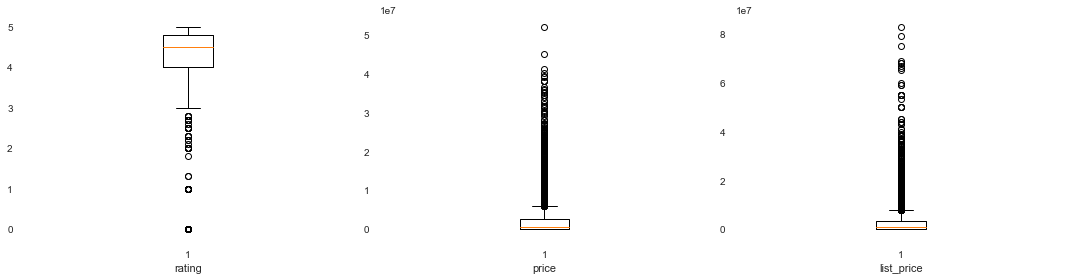

In [ ]:
# Vẽ biểu đồ boxplot 
Lib.visualization_boxplot(['rating', 'price', 'list_price'], product)

Nhận xét: 
- 'rating' nhiều nhất ở giá trị 0 và khoảng 3-5
- 'price' và 'list_price' đa số nhỏ hơn 10,000,000
- 'rating' có phân phối lệch trái, 'price' và 'list_price' có phân phối lệch phải
- 'rating' có lower outliers, 'price' và 'list_price' có upper outliers

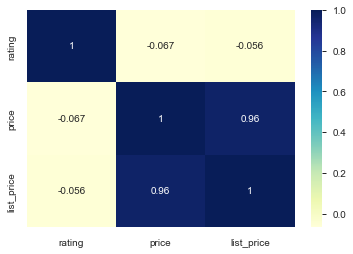

In [ ]:
# Xem xét mối tương quan của các biến số
sns.heatmap(product[['rating', 'price', 'list_price']].corr(), cmap="YlGnBu", annot=True)
plt.show()

Nhận xét:
- 'price' và 'list_price' có mối quan hệ tương quan thuận rất mạnh 0.96
- 'rating' không tương quan với 'price', 'list_price'

### -- Categorical variables

In [ ]:
# Tạo cột thông tin về ngành hàng tên là 'main_group' từ 'group' 
product['main_group'] = product['group'].apply(lambda x: x.split('/')[0])
product.head(3)

,item_id,name,description,rating,price,list_price,brand,group,url,image,main_group
0,48102821,Tai nghe Bluetooth Inpods 12 - Cảm biến vân ta...,THÔNG TIN CHI TIẾT\nDung lượng pin 300\nThời g...,4.0000,77000,300000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-inpods-12-cam-bien-...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Thiết Bị Số - Phụ Kiện Số
1,52333193,Tai nghe bluetooth không dây F9 True wireless ...,THÔNG TIN CHI TIẾT\nDung lượng pin 2000mah\nTh...,4.5000,132000,750000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-khong-day-f9-true-w...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Thiết Bị Số - Phụ Kiện Số
2,299461,Chuột Không Dây Logitech M331 Silent - Hàng Ch...,THÔNG TIN CHI TIẾT\nThương hiệu Logitech\nĐộ p...,4.8000,299000,399000,Logitech,Thiết Bị Số - Phụ Kiện Số/Phụ kiện máy tính và...,https://chuot-khong-day-logitech-m331-silent-p...,https://salt.tikicdn.com/cache/280x280/media/c...,Thiết Bị Số - Phụ Kiện Số


In [ ]:
print('- Số ngành hàng:', product.main_group.nunique())
print('- Bao gồm:\n', product.main_group.unique())

- Số ngành hàng: 9
- Bao gồm:
 ['Thiết Bị Số - Phụ Kiện Số' 'Hàng Quốc Tế'
 'Laptop - Máy Vi Tính - Linh kiện' 'Máy Ảnh - Máy Quay Phim'
 'Ô Tô - Xe Máy - Xe Đạp' 'Điện Thoại - Máy Tính Bảng'
 'Nhà Cửa - Đời Sống' 'Đồng hồ và Trang sức' 'Điện Tử - Điện Lạnh']


main_group
Thiết Bị Số - Phụ Kiện Số           1061
Điện Tử - Điện Lạnh                  966
Máy Ảnh - Máy Quay Phim              964
Laptop - Máy Vi Tính - Linh kiện     898
Điện Thoại - Máy Tính Bảng           313
Hàng Quốc Tế                           5
Ô Tô - Xe Máy - Xe Đạp                 2
Nhà Cửa - Đời Sống                     1
Đồng hồ và Trang sức                   1
dtype: int64


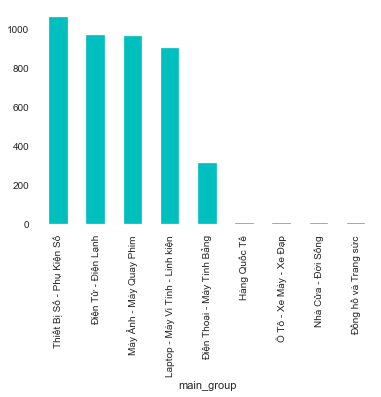

In [ ]:
count = product.groupby(product['main_group']).size().sort_values(ascending=False)
count.plot.bar(color='c')
print(count)
plt.show()

Nhận xét:
- 'Laptop - Máy Vi Tính - Linh kiện', 'Máy Ảnh - Máy Quay Phim', 'Thiết Bị Số - Phụ Kiện Số', 'Điện Tử - Điện Lạnh' là 4 ngành hàng có nhiều sản phẩm nhất, sau đó đến 'Điện Thoại - Máy Tính Bảng'
- 'Hàng Quốc Tế' có 5 sản phẩm
- 'Ô Tô - Xe Máy - Xe Đạp', 'Nhà Cửa - Đời Sống', 'Đồng hồ và Trang sức' chỉ có 1-2 sản phẩm => có thể những sản phẩm này sẽ không có sản phẩm tương đồng 
    => Ta có thể lựa chọn: 1/drop những sản phẩm này hoặc 2/giữ lại. 
    Trong trường hợp giữ lại, recommendation system có thể trả về thông báo 'Không có sản phẩm tượng tự' hoặc vẫn sẽ recommend những sản phẩm không tương đồng. Điều này có thể chấp nhận được, vì trên thực tế doanh nghiệp luôn muốn giới thiệu nhiều sản phẩm nhất có thể tới người tiêu dùng. 

In [ ]:
# Xem xét cột 'brand'
product.brand.unique()

array(['OEM', 'Logitech', 'Acome', 'Apple', 'JBL', 'Xiaomi', 'Hoco',
       'Samsung', 'Baseus', 'Sony', 'QCY', 'TP-Link', 'Robot', 'AMOI',
       'LANITH', 'Sanag', 'Anker', 'SIDOTECH', 'YORN', 'SanDisk',
       'ITelecom', 'Dada', 'Lahutech', 'LG', 'Dell', 'Vinaphone',
       'Viettel', 'Razer', ' GAOMON', 'CAPARIES', 'Aturos', 'vivan',
       ' JBL', 'Orico ', 'HAYLOU', 'Helios', 'SoundPEATS', 'DareU', 'TW',
       'AMA', 'Zealot ', 'AuKey', 'GUTEK', 'Photodesign VN', 'UGREEN',
       'BYZ', 'HXSJ', 'PKCB', 'SADA', 'Microsoft', 'CONVI', 'AION',
       'Mai Lee', 'HiBow', 'ROBINLUX', 'FLYDIGI ', 'Mobifone', 'RAVPower',
       'ICASE', 'Memo', 'Dalugi', 'Microlab', 'Wacom', 'AMAZFIT',
       'Cooler Master', 'Inphic', 'Realme', 'Soundcore by Anker', '\tOEM',
       'Harman Kardon', 'UAG', 'KIOMIC', 'Bosston', 'AKKO', 'Smart Case',
       'E-DRA', 'Tamayoko', 'Fuhlen', 'Handtown', 'Netac', 'Gor',
       'VinBuy', 'CHOETECH', 'I-Telecom', 'Remax', 'Tronsmart', 'V-TECH',
       'Huawei',

In [ ]:
# Sửa lỗi chính tả '\tOEM' thanh 'OEM'
product.brand[product.brand=='\tOEM']='OEM'

In [ ]:
print('- Số thương hiệu:', product.brand.nunique())
print('- 20 thương hiệu trong đó là:\n', product.brand.unique()[:20])

- Số thương hiệu: 510
- 20 thương hiệu trong đó là:
 ['OEM' 'Logitech' 'Acome' 'Apple' 'JBL' 'Xiaomi' 'Hoco' 'Samsung' 'Baseus'
 'Sony' 'QCY' 'TP-Link' 'Robot' 'AMOI' 'LANITH' 'Sanag' 'Anker' 'SIDOTECH'
 'YORN' 'SanDisk']


brand
OEM           1071
Samsung        190
Sony            94
LG              93
Panasonic       83
Yoosee          73
SanDisk         69
UGREEN          64
TP-Link         64
Apple           63
Logitech        61
Xiaomi          57
Sharp           55
Electrolux      48
Dell            48
Toshiba         42
WD              39
Asus            38
Canon           35
Baseus          35
dtype: int64


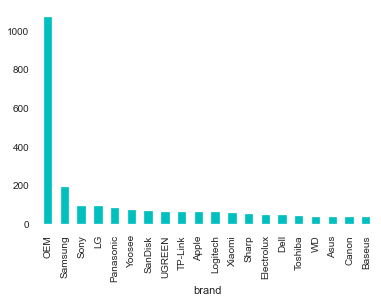

In [ ]:
count = product.groupby(product['brand']).size().sort_values(ascending=False)[:20]
count.plot.bar(color='c')
print(count)
plt.show()

Nhận xét:
- OEM là thương hiệu phổ biến nhất (~25%), sau đó đến Samsung, Panasonic, LG, Sony
- Ngoại trừ OEM (chưa biết), các thương hiệu phổ biến đều là thương hiệu có các sản phẩm công nghệ, điện tử

In [ ]:
product.groupby(['main_group','brand']).agg({'item_id':'count'}).sort_values('item_id',ascending=False)[:10]

item_id
main_group                       brand            
Thiết Bị Số - Phụ Kiện Số        OEM           356
Máy Ảnh - Máy Quay Phim          OEM           345
Điện Tử - Điện Lạnh              OEM           219
Laptop - Máy Vi Tính - Linh kiện OEM           142
Điện Tử - Điện Lạnh              Samsung        87
                                 LG             80
Máy Ảnh - Máy Quay Phim          Yoosee         72
Laptop - Máy Vi Tính - Linh kiện Samsung        63
Thiết Bị Số - Phụ Kiện Số        Logitech       61
Laptop - Máy Vi Tính - Linh kiện TP-Link        60

Nhận xét:
- Trong 4 ngành hàng chủ yếu (công nghệ, điện tử), thuơng hiệu chiếm nhiều nhất cũng là OEM
- Samsung và LG là thương hiệu có nhiều sản phấm nhất trong 'Điện Tử - Điện Lạnh'

# Step 3: Data preparation

In [ ]:
# tạo cột 'content' kết hợp từ 2 cột 'name' và 'description'
product['content'] = product['name'] + '\n' +  product['description']

In [ ]:
product['content'][0]

'Tai nghe Bluetooth Inpods 12 - Cảm biến vân tay, chống nước,màu sắc đa dạng- 5 màu sắc lựa chọn\nTHÔNG TIN CHI TIẾT\nDung lượng pin 300\nThời gian pin - Thời gian nghe nhạc liên tục từ 2.5-4h - Thời gian sạc đầy chỉ khoảng 60p - Thời gian chờ lên tới 140 giờ\nBluetooth 5\nThương hiệu OEM\nXuất xứ thương hiệu Trung Quốc\nĐộ nhạy cảm biến vân tay\nModel i12\nLoại Jack cắm USB Cable\nTrọng lượng 300g\nThời gian sử dụng\n- Thời gian nghe nhạc liên tục từ 2.5-4h\nSKU 4096608751631\nMÔ TẢ SẢN PHẨM\nINPOD 12 là phiên bản nâng cấp mới nhất , tai nghe Bluetooth 5.0 có thiết kế tỉ lệ chuẩn 1:1 với tai Airpod chính hãng\nLược bỏ nút bấm trên thân tai thay vào đó là nút cảm ứng sử dụng dễ dàng và thuận tiện hơn\nThao tác nhận cuộc gọi đến, chuyển nhạc...một cách dễ dàng chỉ bằng 1 chạm\nBluetooth 5.0 mới nhất cho kết nối vô cùng ổn định\n- Bluetooth 5.0 mới nhất cho kết nối vô cùng ổn định\n- 2 tai nghe tự kết nối với nhau khi được lấy ra từ dock sạc\n- Chất âm và thời lượng pin được cải thiện tố

Nhận xét:
- Các câu trong 'content' được phân cách bởi '\n'
- 'content' chứa nhiều ký tự đặc biệt
- Có một số nội dung bị lặp lại. Ví dụ: nội dung '- Thời gian nghe nhạc liên tục từ 2.5-4h' trong product['content'][0] => Cần loại bỏ
- Tất cả các 'content' đều chứa nội dung giống nhau 'THÔNG TIN CHI TIẾT', 'MÔ TẢ SẢN PHẨM' và nội dung chung của tiki ở cuối đoạn 'Giá sản phẩm trên Tiki đã bao gồm thuế theo luật hiện hành... phụ phí hàng cồng kềnh, ...\n' => Cần loại bỏ
- Trong 'content' một số phần tử chứa 'SKU', ví dụ 'SKU 4096608751631' là số unique nên có thể loại bỏ

In [ ]:
# clean 'content' trả về list các câu
list_to_remove = ['thông tin chi tiết', 'mô tả sản phẩm', 
                  'giá sản phẩm trên tiki đã bao gồm thuế theo luật hiện hành  tuy nhiên tuỳ vào từng loại sản phẩm hoặc phương thức  địa chỉ giao hàng mà có thể phát sinh thêm chi phí khác như phí vận chuyển  phụ phí hàng cồng kềnh']

product['clean_content'] = product['content'].apply(lambda x: Lib.clean_content(x, list_to_remove))

In [ ]:
product['clean_content'][0]

['',
 'trọng lượng 300g',
 'dung lượng pin 300',
 'loại jack cắm usb cable',
 'thời gian sạc đầy chỉ khoảng 60p',
 '2 tai nghe tự kết nối với nhau khi được lấy ra từ dock sạc',
 'dock sạc tiện lợi cho tới 4 lần sạc đầy pin tai nghe',
 'model i12',
 'chất âm và thời lượng pin được cải thiện tối ưu',
 'bluetooth 5',
 'tai nghe bluetooth inpods 12   cảm biến vân tay  chống nước màu sắc đa dạng  5 màu sắc lựa chọn',
 'độ nhạy cảm biến vân tay',
 'inpod 12 là phiên bản nâng cấp mới nhất   tai nghe bluetooth 5 0 có thiết kế tỉ lệ chuẩn 1 1 với tai airpod chính hãng',
 'thời gian chờ lên tới 140 giờ',
 'các thiết bị tương thích  các thiết bị bluetooth như cho xiaomi  samsung  apple  huawei  oppo  vivo  lenovo  tablet',
 'thời gian sử dụng',
 'thời gian nghe nhạc liên tục từ 2 5 4h',
 'bluetooth 5 0 mới nhất cho kết nối vô cùng ổn định',
 'thời gian pin   thời gian nghe nhạc liên tục từ 2 5 4h   thời gian sạc đầy chỉ khoảng 60p   thời gian chờ lên tới 140 giờ',
 'lược bỏ nút bấm trên thân tai 

In [ ]:
# join các câu thành 1 đoạn
product['clean_content'] = product['clean_content'].apply(lambda x: ' '.join(x))
product.head(2)

,item_id,name,description,rating,price,list_price,brand,group,url,image,main_group,content,clean_content
0,48102821,Tai nghe Bluetooth Inpods 12 - Cảm biến vân ta...,THÔNG TIN CHI TIẾT\nDung lượng pin 300\nThời g...,4.0000,77000,300000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-inpods-12-cam-bien-...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Thiết Bị Số - Phụ Kiện Số,Tai nghe Bluetooth Inpods 12 - Cảm biến vân ta...,trọng lượng 300g dung lượng pin 300 loại jack...
1,52333193,Tai nghe bluetooth không dây F9 True wireless ...,THÔNG TIN CHI TIẾT\nDung lượng pin 2000mah\nTh...,4.5000,132000,750000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-khong-day-f9-true-w...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Thiết Bị Số - Phụ Kiện Số,Tai nghe bluetooth không dây F9 True wireless ...,công nghệ khử tiếng ồn cho âm thanh trung thự...


In [ ]:
product['clean_content'][0]

' trọng lượng 300g dung lượng pin 300 loại jack cắm usb cable thời gian sạc đầy chỉ khoảng 60p 2 tai nghe tự kết nối với nhau khi được lấy ra từ dock sạc dock sạc tiện lợi cho tới 4 lần sạc đầy pin tai nghe model i12 chất âm và thời lượng pin được cải thiện tối ưu bluetooth 5 tai nghe bluetooth inpods 12   cảm biến vân tay  chống nước màu sắc đa dạng  5 màu sắc lựa chọn độ nhạy cảm biến vân tay inpod 12 là phiên bản nâng cấp mới nhất   tai nghe bluetooth 5 0 có thiết kế tỉ lệ chuẩn 1 1 với tai airpod chính hãng thời gian chờ lên tới 140 giờ các thiết bị tương thích  các thiết bị bluetooth như cho xiaomi  samsung  apple  huawei  oppo  vivo  lenovo  tablet thời gian sử dụng thời gian nghe nhạc liên tục từ 2 5 4h bluetooth 5 0 mới nhất cho kết nối vô cùng ổn định thời gian pin   thời gian nghe nhạc liên tục từ 2 5 4h   thời gian sạc đầy chỉ khoảng 60p   thời gian chờ lên tới 140 giờ lược bỏ nút bấm trên thân tai thay vào đó là nút cảm ứng sử dụng dễ dàng và thuận tiện hơn xuất xứ thương h

In [ ]:
# Thực hiện word_tokenize của package underthesea
product['content_wt'] = product['clean_content'].apply(lambda x: word_tokenize(x, format='text'))

In [ ]:
product['content_wt'][0]

'trọng_lượng 300 g dung_lượng pin 300 loại jack cắm usb cable thời_gian sạc đầy chỉ khoảng 60 p 2 tai nghe tự kết_nối với nhau khi được lấy ra từ dock sạc dock sạc tiện_lợi cho tới 4 lần sạc đầy pin tai_nghe model i12 chất âm và thời_lượng pin được cải_thiện tối_ưu bluetooth 5 tai_nghe bluetooth inpods 12 cảm_biến vân tay chống nước màu_sắc đa_dạng 5 màu_sắc lựa_chọn độ nhạy_cảm_biến vân tay inpod 12 là phiên_bản nâng_cấp mới nhất tai_nghe bluetooth 5 0 có thiết_kế tỉ_lệ chuẩn 1 1 với tai airpod chính hãng thời_gian chờ lên tới 140 giờ các thiết_bị tương_thích các thiết_bị bluetooth như cho xiaomi samsung apple huawei oppo vivo lenovo tablet thời_gian sử_dụng thời_gian nghe nhạc liên_tục từ 2 5 4 h bluetooth 5 0 mới nhất cho kết_nối vô_cùng ổn_định thời_gian pin thời_gian nghe nhạc liên_tục từ 2 5 4 h thời_gian sạc đầy chỉ khoảng 60 p thời_gian chờ lên tới 140 giờ lược_bỏ nút bấm trên thân tai thay vào đó là nút cảm_ứng sử_dụng dễ_dàng và thuận_tiện hơn xuất_xứ thương_hiệu trung quốc t

# Step 4: Modeling & Evaluation

## -- Gensim

In [ ]:
# import vietnamese stopwords
STOP_WORD_FILE = 'data/vietnamese-stopwords.txt'
with open(STOP_WORD_FILE, 'r', encoding='utf-8') as file:
    stop_words = file.read()
stop_words = stop_words.split('\n') 

# create tfidf model, corpora dictionary, similarity in sparse matrix
tfidf, dictionary, index_sparse_matrix= Lib.gensim_preparation(product, stop_words)

In [ ]:
# Select product item_id = 29246309
Lib.gensim_get_recommendation(product, tfidf, dictionary, index_sparse_matrix, 29246309)

*** SELECTED PRODUCT ***


,item_id,name,description,rating,price,list_price,brand,group,url
4208,29246309,Máy sấy Electrolux 8 Kg EDV805JQSA,THÔNG TIN CHI TIẾT\nBảng điều khiển Điều khiển...,4.4000,8790000,11290000,Electrolux,Điện Tử - Điện Lạnh/Máy sấy quần áo,https://may-say-electrolux-8-kg-edv805jqsa-p29...


*** 5 RECOMMENDED PRODUCTS ***


,item_id,name,description,rating,price,list_price,brand,group,url,sim_score
4205,29245831,Máy sấy Electrolux 8 Kg EDV805JQWA,THÔNG TIN CHI TIẾT\nBảng điều khiển Điện tử\nT...,5.0000,8149000,10690000,Electrolux,Điện Tử - Điện Lạnh/Máy sấy quần áo,https://may-say-electrolux-8-kg-edv805jqwa-p29...,0.9002
3937,29248443,Máy Sấy Cửa Trước Electrolux EDV705HQWA (7kg) ...,THÔNG TIN CHI TIẾT\nBảng điều khiển Điện tử\nT...,5.0000,6950000,9990000,Electrolux,Điện Tử - Điện Lạnh/Máy sấy quần áo,https://may-say-cua-truoc-electrolux-edv705hqw...,0.9000
3255,29245829,Máy sấy Electrolux 7 Kg EDV705HQWA,THÔNG TIN CHI TIẾT\nBảng điều khiển Điện tử\nT...,4.2000,6990000,9990000,Electrolux,Điện Tử - Điện Lạnh/Máy sấy quần áo,https://may-say-electrolux-7-kg-edv705hqwa-p29...,0.8996
3632,29244640,Máy sấy Electrolux 7 Kg EDV705HQWA,THÔNG TIN CHI TIẾT\nBảng điều khiển Điện tử\nT...,4.0000,6949000,9990000,Electrolux,Điện Tử - Điện Lạnh/Máy sấy quần áo,https://may-say-electrolux-7-kg-edv705hqwa-p29...,0.8996
3300,29247864,Máy sấy Electrolux 7 Kg EDV705HQWA,THÔNG TIN CHI TIẾT\nBảng điều khiển Điều khiển...,4.6000,7079000,9990000,Electrolux,Điện Tử - Điện Lạnh/Máy sấy quần áo,https://may-say-electrolux-7-kg-edv705hqwa-p29...,0.8984


In [ ]:
# Select product item_id = 43107185
Lib.gensim_get_recommendation(product, tfidf, dictionary, index_sparse_matrix, 43107185)

*** SELECTED PRODUCT ***


,item_id,name,description,rating,price,list_price,brand,group,url
1001,43107185,Camera chống trộm Xiaomi Mi Home 360° 1080P 20...,THÔNG TIN CHI TIẾT\nThương hiệu Xiaomi\nXuất x...,4.3000,749000,899000,Xiaomi,Máy Ảnh - Máy Quay Phim/Camera Giám Sát/Camera IP,https://camera-chong-trom-xiaomi-mi-home-360-1...


*** 5 RECOMMENDED PRODUCTS ***


,item_id,name,description,rating,price,list_price,brand,group,url,sim_score
1018,7230439,Camera chống trộm Xiaomi 360° 1080P Mi Home (T...,THÔNG TIN CHI TIẾT\nThương hiệu Xiaomi\nKích t...,4.7000,749000,899000,Xiaomi,Máy Ảnh - Máy Quay Phim/Camera Giám Sát/Camera IP,https://camera-chong-trom-xiaomi-360-1080p-mi-...,0.6225
1293,21068237,Camera chống trộm Xiaomi 360° 1080P Mi Home (T...,THÔNG TIN CHI TIẾT\nThương hiệu Xiaomi\nKích t...,0.0000,799000,899000,Xiaomi,Máy Ảnh - Máy Quay Phim/Camera Giám Sát/Camera IP,https://camera-chong-trom-xiaomi-360-1080p-mi-...,0.6150
1806,8406093,Camera Quan sát Xiaomi Mi Home 360° 1080P (Tặn...,THÔNG TIN CHI TIẾT\nThương hiệu Xiaomi\nKích t...,4.7000,890000,1075000,Xiaomi,Máy Ảnh - Máy Quay Phim/Camera Giám Sát/Camera IP,https://camera-quan-sat-xiaomi-mi-home-360-108...,0.5547
1114,7932267,Camera IP Xiaomi MJSXJ02CM Mi Home Security Ca...,THÔNG TIN CHI TIẾT\nThương hiệu Xiaomi\nKích t...,4.6000,729000,890000,Xiaomi,Máy Ảnh - Máy Quay Phim/Camera Giám Sát/Camera IP,https://camera-ip-xiaomi-mjsxj02cm-mi-home-sec...,0.5320
1173,10644571,Camera Hồng Ngoại IP Xiaomi Mi Smart Home Basi...,THÔNG TIN CHI TIẾT\nThương hiệu Xiaomi\nKích t...,4.5000,459000,530000,Xiaomi,Máy Ảnh - Máy Quay Phim/Camera Giám Sát/Camera IP,https://camera-hong-ngoai-ip-xiaomi-mi-smart-h...,0.4431


## -- Cosine similarity

In [ ]:
# tính toán cosine_similarities
cosine_similarities = Lib.cosine_preparation(product, stop_words)

In [ ]:
# lấy 5 sản phẩm tương quan nhất của sản phẩm có item_id = 29246309
Lib.cosine_recommendation(product, cosine_similarities, 29246309)

*** SELECTED PRODUCT ***


,item_id,name,description,rating,price,list_price,brand,group,url
4208,29246309,Máy sấy Electrolux 8 Kg EDV805JQSA,THÔNG TIN CHI TIẾT\nBảng điều khiển Điều khiển...,4.4000,8790000,11290000,Electrolux,Điện Tử - Điện Lạnh/Máy sấy quần áo,https://may-say-electrolux-8-kg-edv805jqsa-p29...


*** 5 RECOMMENDED PRODUCTS ***


,item_id,name,description,rating,price,list_price,brand,group,url,consine_sim_score
3937,29248443,Máy Sấy Cửa Trước Electrolux EDV705HQWA (7kg) ...,THÔNG TIN CHI TIẾT\nBảng điều khiển Điện tử\nT...,5.0000,6950000,9990000,Electrolux,Điện Tử - Điện Lạnh/Máy sấy quần áo,https://may-say-cua-truoc-electrolux-edv705hqw...,0.9107
3632,29244640,Máy sấy Electrolux 7 Kg EDV705HQWA,THÔNG TIN CHI TIẾT\nBảng điều khiển Điện tử\nT...,4.0000,6949000,9990000,Electrolux,Điện Tử - Điện Lạnh/Máy sấy quần áo,https://may-say-electrolux-7-kg-edv705hqwa-p29...,0.9102
3255,29245829,Máy sấy Electrolux 7 Kg EDV705HQWA,THÔNG TIN CHI TIẾT\nBảng điều khiển Điện tử\nT...,4.2000,6990000,9990000,Electrolux,Điện Tử - Điện Lạnh/Máy sấy quần áo,https://may-say-electrolux-7-kg-edv705hqwa-p29...,0.9102
4205,29245831,Máy sấy Electrolux 8 Kg EDV805JQWA,THÔNG TIN CHI TIẾT\nBảng điều khiển Điện tử\nT...,5.0000,8149000,10690000,Electrolux,Điện Tử - Điện Lạnh/Máy sấy quần áo,https://may-say-electrolux-8-kg-edv805jqwa-p29...,0.9095
3300,29247864,Máy sấy Electrolux 7 Kg EDV705HQWA,THÔNG TIN CHI TIẾT\nBảng điều khiển Điều khiển...,4.6000,7079000,9990000,Electrolux,Điện Tử - Điện Lạnh/Máy sấy quần áo,https://may-say-electrolux-7-kg-edv705hqwa-p29...,0.9087


In [ ]:
# lấy 5 sản phẩm tương quan nhất của sản phẩm có item_id = 43107185
Lib.cosine_recommendation(product, cosine_similarities, 43107185)

*** SELECTED PRODUCT ***


,item_id,name,description,rating,price,list_price,brand,group,url
1001,43107185,Camera chống trộm Xiaomi Mi Home 360° 1080P 20...,THÔNG TIN CHI TIẾT\nThương hiệu Xiaomi\nXuất x...,4.3000,749000,899000,Xiaomi,Máy Ảnh - Máy Quay Phim/Camera Giám Sát/Camera IP,https://camera-chong-trom-xiaomi-mi-home-360-1...


*** 5 RECOMMENDED PRODUCTS ***


,item_id,name,description,rating,price,list_price,brand,group,url,consine_sim_score
1018,7230439,Camera chống trộm Xiaomi 360° 1080P Mi Home (T...,THÔNG TIN CHI TIẾT\nThương hiệu Xiaomi\nKích t...,4.7000,749000,899000,Xiaomi,Máy Ảnh - Máy Quay Phim/Camera Giám Sát/Camera IP,https://camera-chong-trom-xiaomi-360-1080p-mi-...,0.7104
1293,21068237,Camera chống trộm Xiaomi 360° 1080P Mi Home (T...,THÔNG TIN CHI TIẾT\nThương hiệu Xiaomi\nKích t...,0.0000,799000,899000,Xiaomi,Máy Ảnh - Máy Quay Phim/Camera Giám Sát/Camera IP,https://camera-chong-trom-xiaomi-360-1080p-mi-...,0.7018
1806,8406093,Camera Quan sát Xiaomi Mi Home 360° 1080P (Tặn...,THÔNG TIN CHI TIẾT\nThương hiệu Xiaomi\nKích t...,4.7000,890000,1075000,Xiaomi,Máy Ảnh - Máy Quay Phim/Camera Giám Sát/Camera IP,https://camera-quan-sat-xiaomi-mi-home-360-108...,0.6422
1114,7932267,Camera IP Xiaomi MJSXJ02CM Mi Home Security Ca...,THÔNG TIN CHI TIẾT\nThương hiệu Xiaomi\nKích t...,4.6000,729000,890000,Xiaomi,Máy Ảnh - Máy Quay Phim/Camera Giám Sát/Camera IP,https://camera-ip-xiaomi-mjsxj02cm-mi-home-sec...,0.6331
1173,10644571,Camera Hồng Ngoại IP Xiaomi Mi Smart Home Basi...,THÔNG TIN CHI TIẾT\nThương hiệu Xiaomi\nKích t...,4.5000,459000,530000,Xiaomi,Máy Ảnh - Máy Quay Phim/Camera Giám Sát/Camera IP,https://camera-hong-ngoai-ip-xiaomi-mi-smart-h...,0.5307


Nhận xét:
- Có thể thấy Gensim và Consine similarity cho kết quả giống nhau và rất tốt các sản phẩm được recommended đều tương đồng với sản phẩm được chọn.
- Có thể thấy Cosine similarity thực hiện đơn giản hơn (ít bước hơn) => Chọn Cosine Similarity đối với phương pháp Content-based Filtering. 
- => Hãy cùng xem xét việc gợi ý bằng phương pháp Collaborative Filtering thông qua ALS của pyspark

## -- ALS

In [1]:
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q http://archive.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
# !tar -xvf spark-2.4.0-bin-hadoop2.7.tgz
# !pip install -q findspark
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"
# import findspark
# findspark.init()

spark-2.4.0-bin-hadoop2.7/
spark-2.4.0-bin-hadoop2.7/python/
spark-2.4.0-bin-hadoop2.7/python/setup.cfg
spark-2.4.0-bin-hadoop2.7/python/pyspark/
spark-2.4.0-bin-hadoop2.7/python/pyspark/resultiterable.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/python/
spark-2.4.0-bin-hadoop2.7/python/pyspark/python/pyspark/
spark-2.4.0-bin-hadoop2.7/python/pyspark/python/pyspark/shell.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/heapq3.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/join.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/version.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/rdd.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/java_gateway.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/find_spark_home.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/_globals.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/worker.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/accumulators.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/mllib/
spark-2.4.0-bin-hadoop2.7/python/pyspark/mllib/feature.py
spark-2.4.0-bin-hadoop2.7/python/pyspark

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
# %cd '/content/gdrive/MyDrive/LDS0_K273_DamThiMinhPhuong/Project/Project2_RecommendationSystem'

/content/gdrive/MyDrive/LDS0_K273_DamThiMinhPhuong/Project/Project2_RecommendationSystem


In [4]:
# !pip install import_ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2975 sha256=0b1ec18b6185c149ab5d26c5aa352ef6803654781596633a8651006fb4286c1c
  Stored in directory: /root/.cache/pip/wheels/b1/5e/dc/79780689896a056199b0b9f24471e3ee184fbd816df355d5f0
Successfully built import-ipynb


In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col, explode
from pyspark.sql.types import *
from pyspark.sql.functions import isnan, when, count, col, udf
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
import import_ipynb
import Lib

importing Jupyter notebook from Lib.ipynb


In [2]:
SparkContext.setSystemProperty('spark.executor.memory', '12g')
sc = SparkContext(master='local', appName='Recommendation_Tiki')

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/03/27 15:43:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/03/27 15:43:25 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
spark = SparkSession(sc)

In [4]:
#Load data
data = spark.read.csv("data/ReviewClean.csv", header=True, inferSchema=True)

In [5]:
data.count()

359540

In [6]:
data.show(5,truncate=True)

+---+-----------+----------+------+
|_c0|customer_id|product_id|rating|
+---+-----------+----------+------+
|  0|     709310|  10001012|     3|
|  1|   10701688|  10001012|     5|
|  2|   11763074|  10001012|     5|
|  3|    9909549|  10001012|     5|
|  4|    1827148|  10001012|     5|
+---+-----------+----------+------+
only showing top 5 rows



22/03/27 15:43:35 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , customer_id, product_id, rating
 Schema: _c0, customer_id, product_id, rating
Expected: _c0 but found: 
CSV file: file:///Volumes/GoogleDrive/My%20Drive/LDS0_K273_DamThiMinhPhuong/Project/Project2_RecommendationSystem/data/ReviewClean.csv


In [7]:
data.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- rating: integer (nullable = true)



In [8]:
# PREPARE DATA
# Create an indexer
indexer = StringIndexer(inputCol='product_id', 
                        outputCol='product_id_idx')

# Indexer identifies categories in the data
indexer_model = indexer.fit(data)

# Indexer creates a new column with numeric index values
data_indexed = indexer_model.transform(data)

# Repeat the process for the other categorical feature
indexer1 = StringIndexer(inputCol='customer_id', 
                         outputCol='customer_id_idx')
indexer1_model = indexer1.fit(data_indexed)
data_indexed = indexer1_model.transform(data_indexed)

In [9]:
data_indexed.show(5, False)

22/03/27 15:43:40 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
22/03/27 15:43:40 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , customer_id, product_id, rating
 Schema: _c0, customer_id, product_id, rating
Expected: _c0 but found: 
CSV file: file:///Volumes/GoogleDrive/My%20Drive/LDS0_K273_DamThiMinhPhuong/Project/Project2_RecommendationSystem/data/ReviewClean.csv


+---+-----------+----------+------+--------------+---------------+
|_c0|customer_id|product_id|rating|product_id_idx|customer_id_idx|
+---+-----------+----------+------+--------------+---------------+
|0  |709310     |10001012  |3     |2454.0        |216413.0       |
|1  |10701688   |10001012  |5     |2454.0        |24080.0        |
|2  |11763074   |10001012  |5     |2454.0        |26436.0        |
|3  |9909549    |10001012  |5     |2454.0        |3279.0         |
|4  |1827148    |10001012  |5     |2454.0        |370.0          |
+---+-----------+----------+------+--------------+---------------+
only showing top 5 rows



In [10]:
# train/ test split
training, test = data_indexed.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Khởi tạo model và fit với training data
als = ALS(maxIter=20,
         regParam=0.09,
          rank=90,
          userCol='customer_id_idx',
          itemCol='product_id_idx',
          ratingCol='rating',
          coldStartStrategy='drop',
          nonnegative=True    
         )
model = als.fit(training)

In [ ]:
rmse = Lib.ALS_evaluate(model, test)
rmse

'RMSE = 1.2456450521815086'

In [ ]:
data.select('rating').describe().show()

+-------+------------------+
|summary|            rating|
+-------+------------------+
|  count|            359540|
|   mean| 4.473635756800356|
| stddev|1.0178499915613952|
|    min|                 1|
|    max|                 5|
+-------+------------------+



Nhận xét:
- RMSE = 1.24 cao hơn một chút so với stdde v= 1.018 => Thay đổi parameter để tối ưu

In [ ]:
# Khởi tạo model 2 với rank =150
als2 = ALS(maxIter=20,
         regParam=0.09,
          rank=150,
          userCol='customer_id_idx',
          itemCol='product_id_idx',
          ratingCol='rating',
          coldStartStrategy='drop',
          nonnegative=True    
         )
model2 = als2.fit(training)

In [ ]:
rmse2 = Lib.ALS_evaluate(model2, test)
rmse2

'RMSE = 1.2397622298257154'

In [ ]:
# Khởi tạo model 3 với maxIter = 25
als3 = ALS(maxIter=25,
         regParam=0.09,
          rank=100,
          userCol='customer_id_idx',
          itemCol='product_id_idx',
          ratingCol='rating',
          coldStartStrategy='drop',
          nonnegative=True    
         )
model3 = als3.fit(training)

In [ ]:
rmse3 = Lib.ALS_evaluate(model3, test)
rmse3

'RMSE = 1.2010226994530868'

In [ ]:
# Khởi tạo model 4 với maxIter = 30
als4 = ALS(maxIter=30,
         regParam=0.09,
          rank=100,
          userCol='customer_id_idx',
          itemCol='product_id_idx',
          ratingCol='rating',
          coldStartStrategy='drop',
          nonnegative=True    
         )
model4 = als4.fit(training)

In [ ]:
rmse4 = Lib.ALS_evaluate(model4, test)
rmse4

'RMSE = 1.183470198740952'

Nhận xét: 
- Model4 cho kết quả RMSE nhỏ nhất trong 4 model (~1.18) và gần bằng sttdev của ‘rating’ nên chọn Model4 để thực hiện recommendation tới tất cả customers và một số customer cụ thể theo customer_id

In [ ]:
dic_user_rec, rec_product_id_lst = Lib.ALS_get_recommendation(model4, data_indexed, 10701688)

In [ ]:
dic_user_rec

{'customer_id': 10701688,
 'recommendations': [(134, 2927891, 4.901928424835205),
  (2237, 4597127, 4.801959991455078),
  (3325, 50587112, 4.719162464141846),
  (3011, 50592905, 4.714027404785156),
  (4019, 66251373, 4.656266689300537)]}

In [ ]:
# Load file ProductCleaned.csv
# Show 5 recommended products có item_id in rec_product_id_lst
product = spark.read.csv("data/ProductClean.csv", header=True, inferSchema=True)

In [ ]:
product.where(col('item_id').isin(rec_product_id_lst)).select('item_id','name').show(truncate=False)

+--------+---------------------------------------------------------------------------------+
|item_id |name                                                                             |
+--------+---------------------------------------------------------------------------------+
|2927891 | Bảng Vẽ Điện Tử Gaomon 1060Pro - 10x6 inch                                      |
|66251373|Flycam Bugs 20 EIS Gimbal 1 trục + chống rung điện tử - Hàng chính hãng          |
|50587112|Gói hút ẩm Silicagel loại 500gram (1kg có 2 gói, kích thước 23x14cm, có dây treo)|
|4597127 |Giá Treo Tivi Sát Tường Nhập Khẩu North Bayou C3F (40-60 inch)                   |
|50592905|Smart Tivi QLED Samsung 4K 65 inch QA65Q70TA                                     |
+--------+---------------------------------------------------------------------------------+



## -- BaselineOnly

In [26]:
from surprise import BaselineOnly, Reader, Dataset
from surprise.model_selection.validation import cross_validate

In [12]:
data.show(5,truncate=True)

+---+-----------+----------+------+
|_c0|customer_id|product_id|rating|
+---+-----------+----------+------+
|  0|     709310|  10001012|     3|
|  1|   10701688|  10001012|     5|
|  2|   11763074|  10001012|     5|
|  3|    9909549|  10001012|     5|
|  4|    1827148|  10001012|     5|
+---+-----------+----------+------+
only showing top 5 rows



22/03/27 15:45:11 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , customer_id, product_id, rating
 Schema: _c0, customer_id, product_id, rating
Expected: _c0 but found: 
CSV file: file:///Volumes/GoogleDrive/My%20Drive/LDS0_K273_DamThiMinhPhuong/Project/Project2_RecommendationSystem/data/ReviewClean.csv


In [16]:
data_pandas = data.toPandas()
data_pandas.head()

22/03/27 15:47:36 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , customer_id, product_id, rating
 Schema: _c0, customer_id, product_id, rating
Expected: _c0 but found: 
CSV file: file:///Volumes/GoogleDrive/My%20Drive/LDS0_K273_DamThiMinhPhuong/Project/Project2_RecommendationSystem/data/ReviewClean.csv


,_c0,customer_id,product_id,rating
0,0,709310,10001012,3
1,1,10701688,10001012,5
2,2,11763074,10001012,5
3,3,9909549,10001012,5
4,4,1827148,10001012,5


In [23]:
reader = Reader()
data_bo = Dataset.load_from_df(data_pandas[['customer_id', 'product_id', 'rating']], reader)

In [24]:
trainset = data_bo.build_full_trainset()

In [29]:
algorithm = BaselineOnly()
# Run 5-fold cross-validation
results = cross_validate(algorithm, data_bo, measures=['RMSE','MSE'],
                        cv=5, verbose=True)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MSE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9688  0.9775  0.9713  0.9719  0.9643  0.9708  0.0043  
MSE (testset)     0.9385  0.9555  0.9434  0.9446  0.9298  0.9424  0.0084  
Fit time          0.80    0.82    0.86    0.86    0.88    0.84    0.03    
Test time         0.40    0.17    0.18    0.18    0.39    0.26    0.11    


In [31]:
# xem customer_id=10701688 da mua va rate nhung san pham nao
df_select = data_pandas[(data_pandas.customer_id==10701688) & (data_pandas.rating>=3)]
df_select = df_select.set_index('product_id')
df_select

,_c0,customer_id,rating
product_id,,,
10001012,1,10701688,5
2927891,104654,10701688,5


In [32]:
df_select.shape

(2, 3)

In [36]:
df_score = data_pandas[['product_id']]
df_score.head()

,product_id
0,10001012
1,10001012
2,10001012
3,10001012
4,10001012


In [40]:
# Recommend top 10 products for customer_id = 10701688
df_score['EstimateScore'] = df_score['product_id'].apply(lambda x: algorithm.predict(10701688, x).est) # est: get EstimateScore
df_score = df_score.sort_values(by=['EstimateScore'], ascending=False)
df_score = df_score.drop_duplicates()
df_score.head(10)

,product_id,EstimateScore
317068,71523843,4.942251
236121,53080935,4.941757
304212,68025746,4.938861
323201,73179180,4.933457
235585,53056161,4.927793
325744,7395667,4.922542
292446,6431175,4.919827
312005,70771651,4.912473
315368,71197117,4.909505
318544,71896003,4.907844


- Thuật toán BaselineOnly cho kết quả có sai số RMSE ~0.9708, nhỏ hơn so với ALS(model4) ~1.1834 và nhỏ hơn stddev (rating) ~1.0178 
- => Chọn mô hình được xây dựng bởi thuật toán BaselineOnly cho Reccommedation System based on Collaborative Filtering

# Step 5: Report

Kết luận: Recommendation System cần được xây dựng đồng thời theo 2 phương pháp sau:
- Collaborative Filtering: phương pháp xây dựng Recommdation system dựa trên sự tương đồng giữa những người dùng, phù hợp khi khách hàng là thành viên và đã đăng nhập, có lịch sử mua hàng và đánh giá.
- Content-based Filtering: phương pháp xây dựng Recommdation system dựa trên đặc điểm của sản phẩm, phù hợp khi:
    + Người dùng mới chưa mua hàng và chưa có đánh giá sản phẩm
    + Người dùng không phải thành viên/chưa đăng nhập 
    
- Như đã nhận xét ở trên, ta lựa chọn **Cosine Similarity** cho Content-based Filtering và **BaselineOnly()** cho Collaborative Filtering

# Step 6: Deployment & Feedback/Act
Triển khai Recommender System và theo dõi kết quả